<a href="https://colab.research.google.com/github/misko/spf/blob/main/software/notebooks/90_spf_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'prawnukkah'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
! git clone https://github.com/misko/spf.git

Cloning into 'spf'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 208 (delta 113), reused 127 (delta 56), pack-reused 0
Receiving objects: 100% (208/208), 13.95 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [ ]:
from smart_open import open
import pickle
session=pickle.load(
    open('gs://spf-data/sessions_sigma0.0_sources3_n8192_timesteps256_timeinterval0.3_dtbounce/session_00000001.pkl','rb'))
from spf.nn.rf_torch import labels_to_source_images,detector_positions_to_theta_grid,radio_to_image
#generate the images for the session
d={}
d['source_image_at_t']=labels_to_source_images(torch.from_numpy(session['source_positions_at_t'])[None],width)[0]
d['detector_theta_image_at_t']=detector_positions_to_theta_grid(session['detector_position_at_t'][None],width)[0]
d['radio_image_at_t']=radio_to_image(session['beam_former_outputs_at_t'][None],d['detector_theta_image_at_t'][None])[0]
d['radio_image_at_t_normed']=d['radio_image_at_t']/d['radio_image_at_t'].sum(axis=2,keepdims=True).sum(axis=3,keepdims=True)

NameError: ignored

In [ ]:
session['width_at_t'].shape

NameError: ignored

In [ ]:

import matplotlib.pyplot as plt 


def plot_trajectory(ax,
                    positions,
                    width,
                    ms=30,
                    steps_per_fade=10,
                    fadep=0.8,
                    c='b',
                    rings=False,
                    label=None):
  ax.set_xlim([0,width])
  ax.set_ylim([0,width])
  n_steps=positions.shape[0]//steps_per_fade
  if positions.shape[0]%steps_per_fade!=0:
    n_steps+=1
  alpha=1.0
  for n in np.arange(n_steps):
    start=positions.shape[0]-(n+1)*steps_per_fade
    end=start+steps_per_fade
    start=max(0,start)
    ax.plot( positions[start:end,0], positions[start:end,1],'--',alpha=alpha,color=c,label=label)
    alpha*=fadep
  
  ax.plot( positions[-1,0], positions[-1,1],'.',ms=ms,c=c)
  if rings:
    n=4
    for x in range(n):
      ax.plot( positions[-1,0], positions[-1,1],'.',ms=ms*(1.8**x),c=c,alpha=1/n)


In [ ]:
!rm 01_basic*.png

width=session['width_at_t'][0][0]

filenames=[]
plt.ioff()
step_size=4
for idx in np.arange(1,256,step_size):
  fig=plt.figure(figsize=(12,12))
  axs=fig.subplots(2,2)
  for _a in [0,1]:
    for _b in [0,1]:
      if _a==0 and _b==1: 
        continue
      axs[_a,_b].set_xlabel("X (m)")
      axs[_a,_b].set_ylabel("Y (m)")

  axs[0,0].set_title("Position map")
  plot_trajectory(axs[0,0],session['detector_position_at_t'][:idx],width,ms=30,label='detector')
  for n in np.arange(session['source_positions_at_t'].shape[1]):
    rings=(session['broadcasting_positions_at_t'][idx,n,0]==1)
    plot_trajectory(axs[0,0],session['source_positions_at_t'][:idx,n],width,ms=15,c='r',rings=rings,label='emitter %d' % n)
  #axs[0,0].legend()
  handles, labels = axs[0,0].get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  axs[0,0].legend(by_label.values(), by_label.keys())
  #lets draw the radio
  axs[1,0].imshow(d['source_image_at_t'][idx,0].T,origin='lower')
  axs[1,0].set_title("Emitters as image at t=%d" % idx)

  axs[1,1].imshow(d['radio_image_at_t'][idx,0].T,origin='lower')
  axs[1,1].set_title("Radio feature at t=%d" % idx)

  axs[0,1].plot(session['thetas_at_t'][idx],session['beam_former_outputs_at_t'][idx])
  axs[0,1].set_title("Beamformer output at t=%d" % idx)
  fn='01_basic_frame_%04d.png' % idx
  filenames.append(fn)
  fig.savefig(fn)
  plt.close(fig)
plt.ion()

In [ ]:

# importing libraries
from PIL import Image

images=[]
for fn in filenames:
  images.append(Image.open(fn))

images[0].save('01_basic.gif',
               save_all = True, append_images = images[1:], 
               optimize = False, duration = 20)

In [ ]:
!sudo apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.7).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


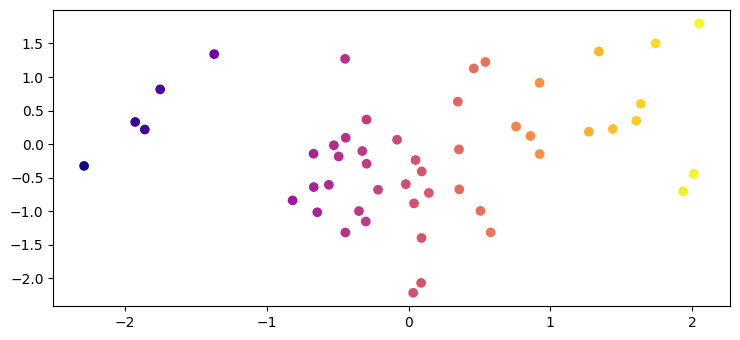

In [23]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

N = 50
x = np.random.randn(N)
y = np.random.randn(N)

plt.scatter(x, y, c=x, cmap="plasma")

plt.show()

In [77]:
import PIL
PIL.ImagePalette.ImagePalette(mode='RGBA')


In [164]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from functools import partial
from PIL import Image
#import matplotlib

#Correct the first frame of gif animations:
def CreateFrameWithAlphaValue(CurrentImage,size):
    width,height=size
    edited_frame = Img.new('RGBA', (width, height))
    edited_frame.putalpha(0)
    edited_frame.paste(CurrentImage, (0, 0))
    return edited_frame

def filenames_to_gif(filenames,
                     output_gif_fn,
                     ms_per_frame=50,
                     quality=75,
                     palette=None,
                     resize=(1200,600)):
        images=[]
        for fn in filenames:
                images.append(Image.open(fn).convert("RGBA").resize(resize))

        images[0].save(output_gif_fn,
                  save_all = True, append_images = images[1:],
                  optimize = False, duration = ms_per_frame,loop=0,quality=quality,palette=palette)
        
def orthogonal_2d(v):
  return np.array([-v[1],v[0]])

def get_grid(width):
        _xy=np.arange(width).astype(np.int16)
        _x,_y=np.meshgrid(_xy,_xy)
        return np.stack((_x,_y)).transpose(2,1,0)

def sin_signal_am_at_time_t(frequency,
                         phase_offset,
                         amplitudes,
                         t):
  phases=2*np.pi*frequency*t+phase_offset
  amplitude_idxs=((phases//(2*np.pi))%amplitudes.shape[0]).astype(int)
  output_signal=np.sin(phases)*np.take(amplitudes,amplitude_idxs)
  output_signal[t<0]=0
  return output_signal

def sin_signal_at_time_t(frequency,
                         phase_offset,
                         t):
  output_signal=np.sin(2*np.pi*frequency*t+phase_offset)  
  output_signal[t<0]=0
  return output_signal

def block_signal_at_time_t(symbols,
                           symbol_duration,
                           t):
  cycle_length=len(symbols) 
  idxs=((t//symbol_duration)%cycle_length).astype(int) # which symbol we are broadcasting
  output_signal=np.take(symbols,idxs)
  output_signal[t<0]=0
  return output_signal

def draw_sampling(detector,emitters,t,axs,max_t,
                  title='Antenna array output',
                  detector_labels=None,
                  ylims=[-1.1,1.1]):
  sampling_n=int(t*d.sampling_frequency)+1 # number of samplings
  if sampling_n==0:
    return
  sampling_times=np.arange(sampling_n)*(1/d.sampling_frequency)
  axs[0].set_title(title)
  axs[-1].set_xlabel("Time")
  if detector_labels is None:
    detector_labels=[ "%d" % idx for idx in range(detector.n_elements)]
  for detector_element_idx,detector_element_pos in enumerate(detector.element_positions):
    z=sampling_times-np.linalg.norm(
              emitters[0].position-detector_element_pos)/d.speed_of_signal
    signal_at_position=np.vstack(
      [ e.signal_at_time_t(
          sampling_times-np.linalg.norm(
              e.position-detector_element_pos)/d.speed_of_signal)[None] for e in emitters ] ).sum(axis=0)
    ax=axs[detector_element_idx]
    ax.plot(sampling_times,
               signal_at_position,
               color='black',alpha=0.2)
    ax.scatter(sampling_times,
               signal_at_position,
               label=detector_labels[detector_element_idx],
               s=6,
               c=signal_at_position,cmap='bwr',vmin=-1, vmax=1)
    ax.legend(loc=2)
    ax.set_ylabel("Signal")
    ax.set_ylim(ylims)
    ax.set_xlim([0,max_t+1/d.sampling_frequency])

def draw_scene(detector,emitters,t,ax,max_t,
               detector_label='Detector element',
               emitter_label='Emitter'
               ):
  ax.cla()
  emitter_positions=np.vstack([ e.position for e in emitters ])
  g=get_grid(detector.width)
  time_at_dist=t-np.linalg.norm(g-emitter_positions[0],axis=2).T/detector.speed_of_signal
  signal_at_position=np.vstack(
      [ e.signal_at_time_t(time_at_dist)[None] for e in emitters ] ).sum(axis=0)
  ax.imshow(signal_at_position,origin='lower',alpha=0.5,cmap='bwr',vmin=-1, vmax=1)
  #draw the receiver antenna
  ax.scatter(d.element_positions[:,0],
             d.element_positions[:,1],s=160,c='b',marker='.')
  #draw the normal to the array
  array_center_normal=(d.position+(detector.width/2)*d.array_normal)
  ax.plot([d.position[0,0],array_center_normal[0,0]],
          [d.position[0,1],array_center_normal[0,1]],linestyle='--',c='b')#+3*array_normal)
  #draw parallel to the array
  a1=d.position-(detector.width/4)*orthogonal_2d(d.array_normal)
  a2=d.position+(detector.width/4)*orthogonal_2d(d.array_normal)
  ax.plot([a1[0,0],a2[0,0]],
          [a1[0,1],a2[0,1]],linestyle='--',c='b')#+3*array_normal)

  ax.scatter(emitter_positions[:,0],
             emitter_positions[:,1],s=40,c='r',marker='.')
  ax.set_xlim([0,detector.width])
  ax.set_ylim([0,detector.width])
  ax.set_xlabel("X in (m)")
  ax.set_ylabel("Y in (m)")
  legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label=detector_label,
                          markerfacecolor='b', markersize=5),
                   Line2D([0], [0], linestyle='--', lw=1, color='b', label='Detector axis'),
                   Line2D([0], [0], marker='o', color='w', label=emitter_label,
                          markerfacecolor='r', markersize=5)]
  ax.legend(handles=legend_elements, loc=2)
  ax.set_title("Spatial setup")

class Emitter:
  def __init__(self,
               position,
               signal_at_time_t):
    self.position=position.reshape(1,2)
    self.signal_at_time_t=signal_at_time_t

class Detector:
  def __init__(self,
               width,
               speed_of_signal,
               position,
               theta,
               n_elements,
               element_offset,
               sampling_frequency):
    self.width=width
    self.speed_of_signal=speed_of_signal
    self.position=position.reshape(1,2)
    self.theta=theta
    self.n_elements=n_elements
    self.element_offset=element_offset
    self.sampling_frequency=sampling_frequency
  
  @property
  def array_normal(self):
    return np.array([
            np.cos(self.theta),
            np.sin(self.theta)])
  @property
  def element_positions(self):
    element_offsets=np.arange(self.n_elements)*self.element_offset
    element_offsets-=element_offsets.mean()
    return self.position.reshape(1,2)+np.vstack([
         orthogonal_2d(self.array_normal)*offset for offset in element_offsets])



In [5]:
width=500
wavelength=width*0.2
speed_of_signal=width*0.1
detector_sampling_frequency=(speed_of_signal/wavelength)*20



In [10]:
#Classic block only positive keys emitter

#detector
d=Detector(
    width=width,
    speed_of_signal=speed_of_signal,
    position=np.array([width*0.4,width*0.3]),
    theta=np.pi*0.4,
    n_elements=2,
    element_offset=wavelength/2,
    sampling_frequency=(speed_of_signal/wavelength)*12 # 20 samples per wavelength,
)
#emitter
emitters=[ Emitter(
    position=np.array([[width*0.8,width*0.4]]),
    signal_at_time_t=partial(
        block_signal_at_time_t,
        np.array([0.5,1,0,0,0.5,1]),
        wavelength/speed_of_signal,
    )
) ]

#plotting parameters
time_steps=140
time_per_step=(1/d.sampling_frequency)

png_filenames=[]
#plt.ion()
plt.ioff()
for t in np.arange(time_steps)*time_per_step:
  fig=plt.figure(figsize=(10,5))
  gs = fig.add_gridspec(d.n_elements,2)
  scene_ax = fig.add_subplot(gs[:, 0])
  detector_element_axs=[fig.add_subplot(gs[0, 1])]
  for idx in range(1,d.n_elements):
    detector_element_axs.append(
      fig.add_subplot(gs[idx, 1],
                      sharex=detector_element_axs[0],
                      sharey=detector_element_axs[0]))
  draw_scene(d,emitters,t,scene_ax,max_t=time_steps*time_per_step,
             detector_label="your ears",emitter_label="bluetooth tag")
  draw_sampling(d,emitters,t,detector_element_axs,max_t=time_steps*time_per_step,
                detector_labels=['left ear','right ear'],
                title='What was heard and when',ylims=[0,1.1])
  fn='out_%0.3f.png' % t
  fig.tight_layout()
  fig.savefig(fn)
  png_filenames.append(fn)
filenames_to_gif(png_filenames,
                  'tag_finding_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150)
plt.ion()


KeyboardInterrupt: ignored

In [12]:
#Classic block emitter

#detector
d=Detector(
    width=width,
    speed_of_signal=speed_of_signal,
    position=np.array([width*0.4,width*0.3]),
    theta=np.pi*0.4,
    n_elements=1,
    element_offset=wavelength/2,
    sampling_frequency=(speed_of_signal/wavelength)*12 # 20 samples per wavelength,
)
#emitter
emitters=[ Emitter(
    position=np.array([[width*0.8,width*0.4]]),
    signal_at_time_t=partial(
        block_signal_at_time_t,
        np.array([1,-1,1,0,0,0,0,0,0]),
        wavelength/speed_of_signal,
    )
) ]

#plotting parameters
time_steps=100
time_per_step=(1/d.sampling_frequency)

png_filenames=[]
#plt.ion()
plt.ioff()
for t in np.arange(time_steps)*time_per_step:
  fig=plt.figure(figsize=(10,5))
  gs = fig.add_gridspec(d.n_elements,2)
  scene_ax = fig.add_subplot(gs[:, 0])
  detector_element_axs=[fig.add_subplot(gs[0, 1])]
  for idx in range(1,d.n_elements):
    detector_element_axs.append(
      fig.add_subplot(gs[idx, 1],
                      sharex=detector_element_axs[0],
                      sharey=detector_element_axs[0]))
  draw_scene(d,emitters,t,scene_ax,max_t=time_steps*time_per_step,
             detector_label='our friend',
             emitter_label='our emission device')
  draw_sampling(d,emitters,t,detector_element_axs,max_t=time_steps*time_per_step,
                title='What our friend hears and when')
  fn='out_%0.3f.png' % t
  fig.tight_layout()
  fig.savefig(fn)
  png_filenames.append(fn)
filenames_to_gif(png_filenames,
                  'block_emitter_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150)
plt.ion()


In [16]:
#Classic sin emitter

#detector
d=Detector(
    width=width,
    speed_of_signal=speed_of_signal,
    position=np.array([width*0.4,width*0.3]),
    theta=np.pi*0.4,
    n_elements=1,
    element_offset=wavelength/2,
    sampling_frequency=(speed_of_signal/wavelength)*12 # 20 samples per wavelength,
)
#emitter
emitters=[ Emitter(
    position=np.array([[width*0.8,width*0.4]]),
    signal_at_time_t=partial(
        sin_signal_at_time_t,
        speed_of_signal/wavelength,
        0,
    )
) ]

#plotting parameters
time_steps=70
time_per_step=(1/d.sampling_frequency)

png_filenames=[]
#plt.ion()
plt.ioff()
for t in np.arange(time_steps)*time_per_step:
  fig=plt.figure(figsize=(10,5))
  gs = fig.add_gridspec(d.n_elements,2)
  scene_ax = fig.add_subplot(gs[:, 0])
  detector_element_axs=[fig.add_subplot(gs[0, 1])]
  for idx in range(1,d.n_elements):
    detector_element_axs.append(
      fig.add_subplot(gs[idx, 1],
                      sharex=detector_element_axs[0],
                      sharey=detector_element_axs[0]))
  draw_scene(d,emitters,t,scene_ax,max_t=time_steps*time_per_step,
             detector_label='our friend',
             emitter_label='our emission device')
  draw_sampling(d,emitters,t,detector_element_axs,max_t=time_steps*time_per_step,
                title='What our friend hears and when')
  fn='out_%0.3f.png' % t
  fig.tight_layout()
  fig.savefig(fn)
  png_filenames.append(fn)
filenames_to_gif(png_filenames,
                  'full_sin_emitter_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150)
plt.ion()

In [17]:
#Classic block sin emitter

#detector
d=Detector(
    width=width,
    speed_of_signal=speed_of_signal,
    position=np.array([width*0.4,width*0.3]),
    theta=np.pi*0.4,
    n_elements=1,
    element_offset=wavelength/2,
    sampling_frequency=(speed_of_signal/wavelength)*12 # 20 samples per wavelength,
)
#emitter
emitters=[ Emitter(
    position=np.array([[width*0.8,width*0.4]]),
    signal_at_time_t=partial(
        sin_signal_am_at_time_t,
        speed_of_signal/wavelength,
        0,
        np.array([1,0.5,1,0,0])
    )
) ]

#plotting parameters
time_steps=120
time_per_step=(1/d.sampling_frequency)

png_filenames=[]
#plt.ion()
plt.ioff()
for t in np.arange(time_steps)*time_per_step:
  fig=plt.figure(figsize=(10,5))
  gs = fig.add_gridspec(d.n_elements,2)
  scene_ax = fig.add_subplot(gs[:, 0])
  detector_element_axs=[fig.add_subplot(gs[0, 1])]
  for idx in range(1,d.n_elements):
    detector_element_axs.append(
      fig.add_subplot(gs[idx, 1],
                      sharex=detector_element_axs[0],
                      sharey=detector_element_axs[0]))
  draw_scene(d,emitters,t,scene_ax,max_t=time_steps*time_per_step,
             detector_label='our friend',
             emitter_label='our emission device')
  draw_sampling(d,emitters,t,detector_element_axs,max_t=time_steps*time_per_step,
                title='What our friend hears and when')
  fn='out_%0.3f.png' % t
  fig.tight_layout()
  fig.savefig(fn)
  png_filenames.append(fn)
filenames_to_gif(png_filenames,
                  'block_sin_emitter_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150)
plt.ion()


In [101]:
#Classic block sin emitter

#detector
d=Detector(
    width=width,
    speed_of_signal=speed_of_signal,
    position=np.array([width*0.4,width*0.3]),
    theta=np.pi*0.4,
    n_elements=2,
    element_offset=wavelength/2,
    sampling_frequency=(speed_of_signal/wavelength)*12 # 20 samples per wavelength,
)
#emitter
emitters=[ Emitter(
    position=np.array([[width*0.8,width*0.4]]),
    signal_at_time_t=partial(
        sin_signal_am_at_time_t,
        speed_of_signal/wavelength,
        0,
        np.array([1,0,1,0,0,0,0])
    )
) ]

#plotting parameters
time_steps=120
time_per_step=(1/d.sampling_frequency)

png_filenames=[]
#plt.ion()
plt.ioff()
for t in np.arange(time_steps)*time_per_step:
  fig=plt.figure(figsize=(10,5))
  gs = fig.add_gridspec(d.n_elements,2)
  scene_ax = fig.add_subplot(gs[:, 0])
  detector_element_axs=[fig.add_subplot(gs[0, 1])]
  for idx in range(1,d.n_elements):
    detector_element_axs.append(
      fig.add_subplot(gs[idx, 1],
                      sharex=detector_element_axs[0],
                      sharey=detector_element_axs[0]))
  draw_scene(d,emitters,t,scene_ax,max_t=time_steps*time_per_step)
  draw_sampling(d,emitters,t,detector_element_axs,max_t=time_steps*time_per_step)
  fn='out_%0.3f.png' % t
  fig.tight_layout()
  fig.savefig(fn) #,pil_kwargs={'palette':PIL.ImagePalette.ImagePalette(mode='RGBA')})
  png_filenames.append(fn)
filenames_to_gif(png_filenames,
                  'simple_sin_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150)
plt.ion()


In [169]:

from scipy.signal import correlate

def cross_correlation(detector,emitters,t,ax,max_time_steps,y_max=10):  
  sampling_n=int(t*d.sampling_frequency)+1 # number of samplings
  if sampling_n==0:
    return
  sampling_times=np.arange(sampling_n)*(1/d.sampling_frequency)
  signal_matrix=[]
  time_delay_to_element=[]
  for detector_element_idx,detector_element_pos in enumerate(detector.element_positions):
    time_delay_to_element.append(np.linalg.norm(
              emitters[0].position-detector_element_pos)/d.speed_of_signal)
    z=sampling_times-time_delay_to_element[-1]
    signal_matrix.append(np.vstack(
      [ e.signal_at_time_t(
          sampling_times-np.linalg.norm(
              e.position-detector_element_pos)/d.speed_of_signal)[None] for e in emitters ] ).sum(axis=0)[None])
  signal_matrix=np.vstack(signal_matrix)
  cross_correlation=correlate(
      signal_matrix[0],
      signal_matrix[1],mode='same')
  delay_arr = np.linspace(-0.5*len(signal_matrix[0])/d.sampling_frequency,
                          0.5*len(signal_matrix[0])/d.sampling_frequency,
                          len(signal_matrix[0]))
  best_delay=delay_arr[np.argmax(cross_correlation)]
  if signal_matrix.sum(axis=1).min()!=0.0:
    ax.axvline(x=best_delay,label='estimated delay=%0.3f' % best_delay,c='orange')
    true_delay=time_delay_to_element[0]-time_delay_to_element[1]
    ax.axvline(x=true_delay,c='r',label='true delay=%0.3f' % true_delay)
    ax.plot(delay_arr,cross_correlation)
    ax.legend()
  ax.set_ylim([-y_max,y_max])
  ax.set_xlim([-max_time_steps/(2*d.sampling_frequency),max_time_steps/(2*d.sampling_frequency)])
  ax.set_ylabel("Cross-correlation")
  ax.set_xlabel("Signal time offset")
  ax.set_title("TDOA estimate time offset")
#fig=plt.figure()
#ax=fig.subplots(1,1)
#cross_correlation(d,emitters,(time_steps-20)*time_per_step,ax)

In [170]:
#More complex wave

#detector
d=Detector(
    width=width,
    speed_of_signal=speed_of_signal*0.5,
    position=np.array([width*0.4,width*0.3]),
    theta=np.pi*0.4,
    n_elements=2,
    element_offset=wavelength/2,
    sampling_frequency=(speed_of_signal/wavelength)*12 # 20 samples per wavelength,
)
#emitter
emitters=[ Emitter(
    position=np.array([[width*0.8,width*0.4]]),
    signal_at_time_t=
    lambda t : np.vstack([ # linear combo of three waves
      sin_signal_am_at_time_t(
          speed_of_signal/wavelength,
          0,
          0.0*np.array([0.3,0.3,0.3]),t
      )[None],
      sin_signal_am_at_time_t(
          speed_of_signal*2/(wavelength),
          np.pi*0.3,
          np.array([0.3,0.3,0.3]),t
      )[None],
      sin_signal_am_at_time_t(
          speed_of_signal/(5*wavelength),
          np.pi*0.6,
          np.array([0.4,0.4,.4]),t,
      )[None],
    ]).sum(axis=0)
) ]

#plotting parameters
time_steps=120
time_per_step=(1/d.sampling_frequency)

png_filenames=[]
#plt.ion()
plt.ioff()
for t in np.arange(time_steps)*time_per_step:
  fig=plt.figure(figsize=(15,5))
  gs = fig.add_gridspec(d.n_elements,3)
  scene_ax = fig.add_subplot(gs[:, 0])
  cross_correlation_ax = fig.add_subplot(gs[:, 2])
  cross_correlation(d,emitters,t,cross_correlation_ax,time_steps)
  detector_element_axs=[fig.add_subplot(gs[0, 1])]
  for idx in range(1,d.n_elements):
    detector_element_axs.append(
      fig.add_subplot(gs[idx, 1],
                      sharex=detector_element_axs[0],
                      sharey=detector_element_axs[0]))
  draw_scene(d,emitters,t,scene_ax,max_t=time_steps*time_per_step)
  draw_sampling(d,emitters,t,detector_element_axs,max_t=time_steps*time_per_step,
                )
  fn='out_%0.3f.png' % t
  fig.tight_layout()
  fig.savefig(fn)
  png_filenames.append(fn)
filenames_to_gif(png_filenames,
                  'tdoa_emitter_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150,resize=(1800,600))
plt.ion()


In [132]:
!rm *.png

In [165]:
filenames_to_gif(png_filenames,
                  'tdoa_emitter_sf%0.3f.gif' % (d.sampling_frequency),
                  ms_per_frame=150,resize=(1800,600))